In [2]:
%load_ext autoreload
%autoreload 2


In [42]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

## Seasonality analysis

In [4]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


### Household consumption 

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler((0,2))
numerical_df = df[df.columns[df.dtypes == float]]
scaled_df = scaler.fit_transform(numerical_df)

scaled_df = pd.DataFrame(scaled_df, index = numerical_df.index, columns = numerical_df.columns)

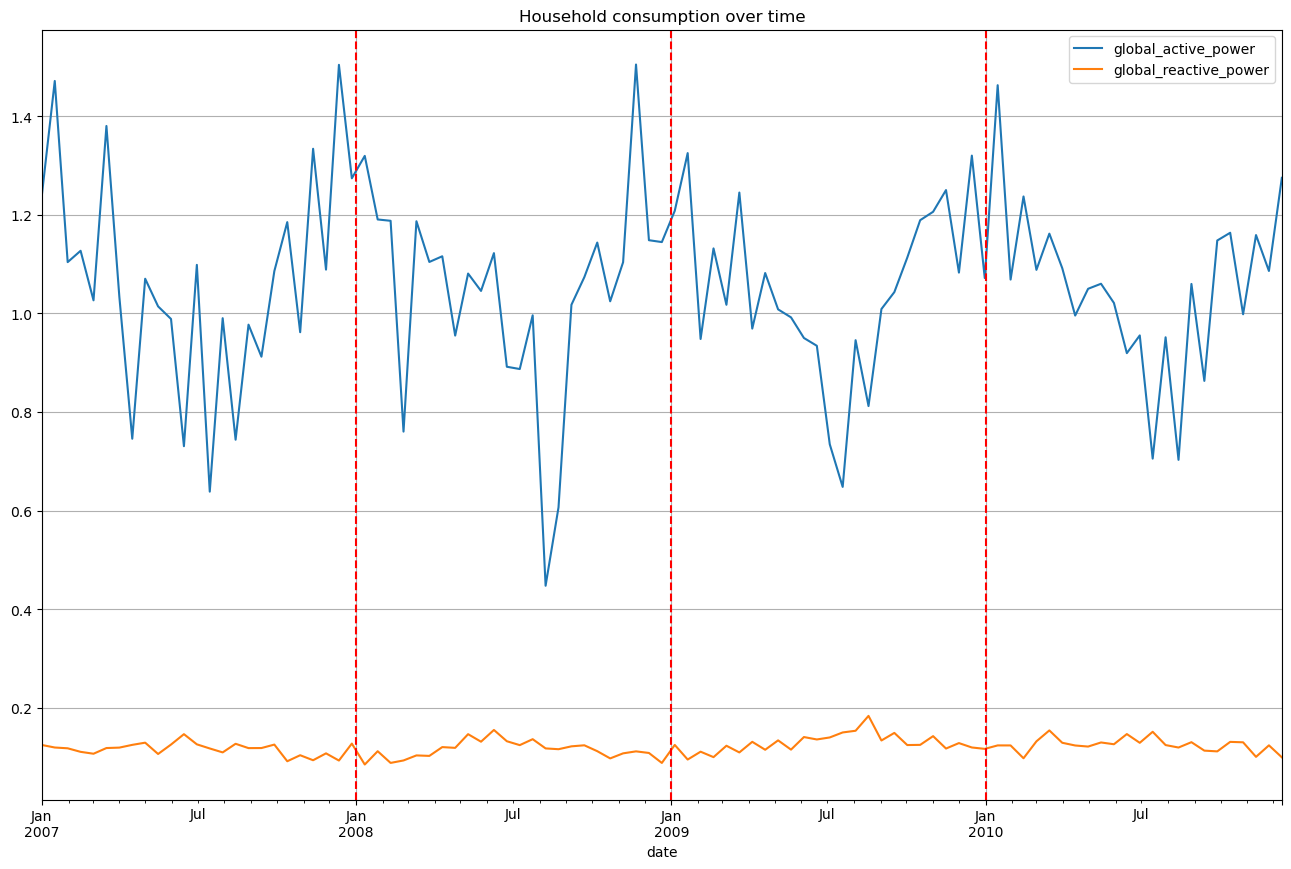

In [194]:
house_consumpion_columns = [
    'global_active_power', 
    'global_reactive_power', 
    # 'voltage',
    # 'global_intensity', 
    # 'sub_metering_1', 
    # 'sub_metering_2',
    # 'sub_metering_3'
]

ax = df[house_consumpion_columns]\
    .groupby(pd.Grouper(freq='15D'))\
    .mean()\
    .plot(figsize=(16,10))

plt.axvline(
    pd.to_datetime('2008-01-01'),
    color = 'red',
    linestyle = '--'
)
plt.axvline(
    pd.to_datetime('2009-01-01'),
    color = 'red',
    linestyle = '--'
)
plt.axvline(
    pd.to_datetime('2010-01-01'),
    color = 'red',
    linestyle = '--'
)
# ax = (clusters.groupby(pd.Grouper(freq="1M")).agg(lambda x : x.mode()[0])).plot()




plt.title("Household consumption over time")

plt.grid()
plt.show()

## Clustering

In [206]:
daily_data_comsumptions

,global_active_power,global_reactive_power
date,,
2007-01-01,1.909031,0.102893
2007-01-02,1.229531,0.103290
2007-01-03,0.359419,0.074742
2007-01-04,1.798130,0.136365
2007-01-05,1.120003,0.124150
...,...,...
2010-12-07,0.770538,0.195934
2010-12-08,0.367846,0.117429
2010-12-09,1.109330,0.136435


### 2 clusters

In [241]:
daily_data_comsumptions = df[house_consumpion_columns]\
    .groupby(pd.Grouper(freq='1D'))\
    .mean()\
    .dropna()

# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(daily_data_comsumptions)

centroids = kmeans.cluster_centers_
centroid_indexes_sorted = np.argsort(centroids[:, 0])
cluster_labels = kmeans.labels_

sorted_cluster_labels = np.zeros_like(cluster_labels)
for i, index in enumerate(centroid_indexes_sorted):
    sorted_cluster_labels[cluster_labels == index] = i

# Assign cluster labels to each data point
daily_data_comsumptions['Cluster'] = sorted_cluster_labels

In [242]:
cluster_freqs = daily_data_comsumptions['Cluster']\
    .groupby(
        pd.Grouper(freq = '1M')
    )\
        .value_counts()

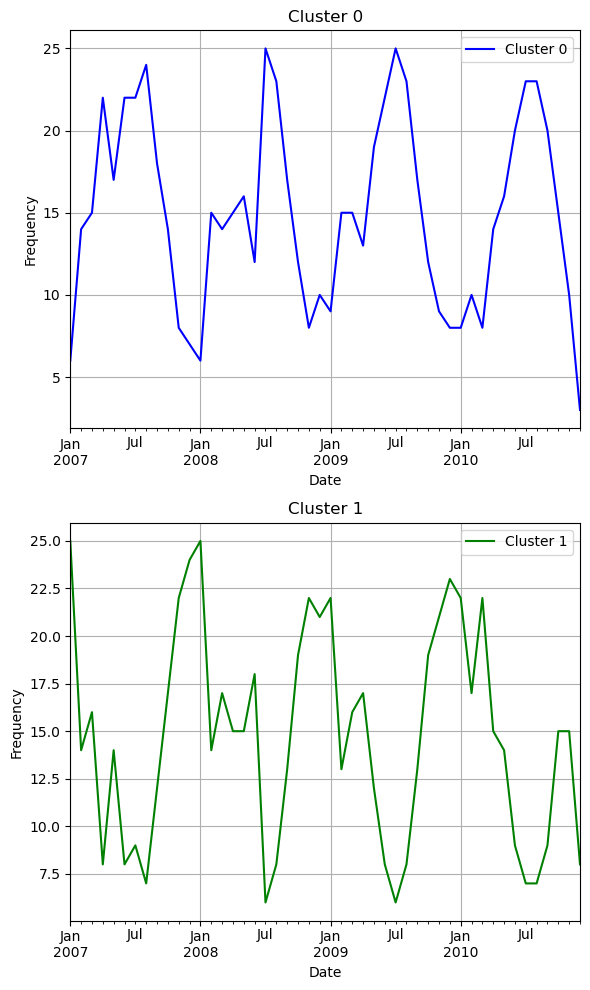

In [247]:

# Create a 2x2 subplot grid
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']
freq = cluster_freqs.rename("frequencies").reset_index(level=1)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# Loop over cluster indexes and plot each cluster on a separate subplot
for cluster_idx, ax in enumerate(axes.flatten()):
    mask = freq['Cluster'] == cluster_idx
    freq[mask]['frequencies'].plot(
        ax=ax,
        label=f'Cluster {cluster_idx}',
        color=colors[cluster_idx]
    )
    ax.set_title(f'Cluster {cluster_idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### 3 clusters

In [249]:
daily_data_comsumptions = df[house_consumpion_columns]\
    .groupby(pd.Grouper(freq='1D'))\
    .mean()\
    .dropna()

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(daily_data_comsumptions)

centroids = kmeans.cluster_centers_
centroid_indexes_sorted = np.argsort(centroids[:, 0])
cluster_labels = kmeans.labels_

sorted_cluster_labels = np.zeros_like(cluster_labels)
for i, index in enumerate(centroid_indexes_sorted):
    sorted_cluster_labels[cluster_labels == index] = i

# Assign cluster labels to each data point
daily_data_comsumptions['Cluster'] = sorted_cluster_labels

In [250]:
cluster_freqs = daily_data_comsumptions['Cluster']\
    .groupby(
        pd.Grouper(freq = '1M')
    )\
        .value_counts()

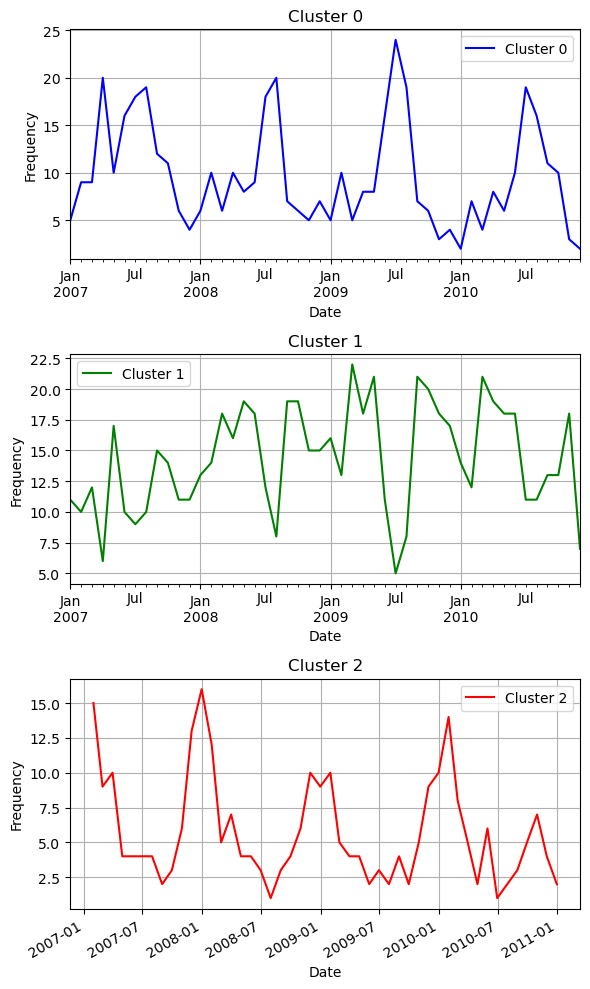

In [251]:

# Create a 2x2 subplot grid
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']
freq = cluster_freqs.rename("frequencies").reset_index(level=1)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,10))

# Loop over cluster indexes and plot each cluster on a separate subplot
for cluster_idx, ax in enumerate(axes.flatten()):
    mask = freq['Cluster'] == cluster_idx
    freq[mask]['frequencies'].plot(
        ax=ax,
        label=f'Cluster {cluster_idx}',
        color=colors[cluster_idx]
    )
    ax.set_title(f'Cluster {cluster_idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### 4 clusters

In [235]:
daily_data_comsumptions = df[house_consumpion_columns]\
    .groupby(pd.Grouper(freq='1D'))\
    .mean()\
    .dropna()

# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(daily_data_comsumptions)

centroids = kmeans.cluster_centers_
centroid_indexes_sorted = np.argsort(centroids[:, 0])
cluster_labels = kmeans.labels_

sorted_cluster_labels = np.zeros_like(cluster_labels)
for i, index in enumerate(centroid_indexes_sorted):
    sorted_cluster_labels[cluster_labels == index] = i

# Assign cluster labels to each data point
daily_data_comsumptions['Cluster'] = sorted_cluster_labels

In [236]:
cluster_freqs = daily_data_comsumptions['Cluster']\
    .groupby(
        pd.Grouper(freq = '1M')
    )\
        .value_counts()

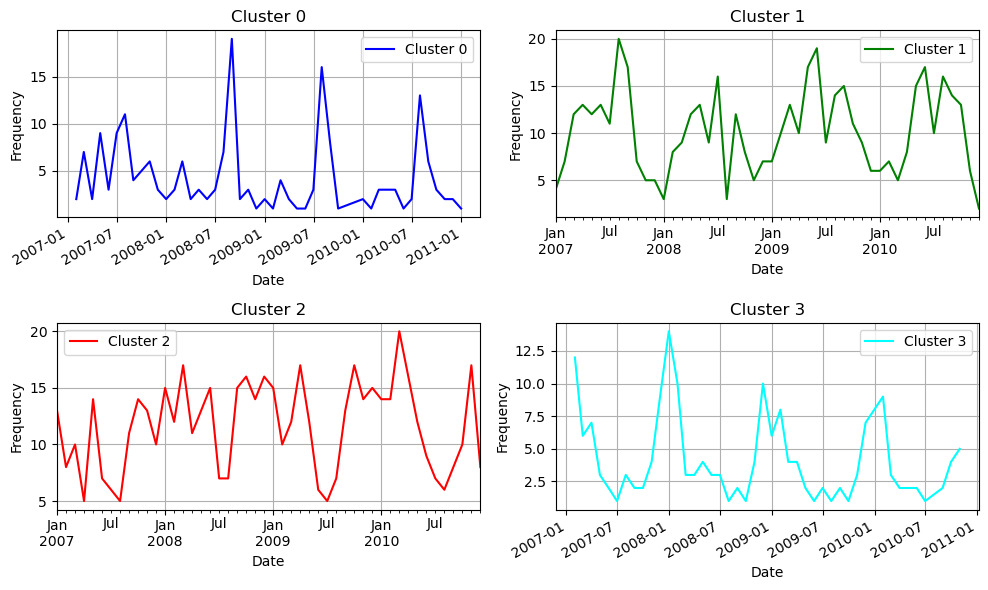

In [237]:

# Create a 2x2 subplot grid
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']
freq = cluster_freqs.rename("frequencies").reset_index(level=1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Loop over cluster indexes and plot each cluster on a separate subplot
for cluster_idx, ax in enumerate(axes.flatten()):
    mask = freq['Cluster'] == cluster_idx
    freq[mask]['frequencies'].plot(
        ax=ax,
        label=f'Cluster {cluster_idx}',
        color=colors[cluster_idx]
    )
    ax.set_title(f'Cluster {cluster_idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Elbow method

In [217]:
variances = []

daily_data_comsumptions = df[house_consumpion_columns]\
    .groupby(pd.Grouper(freq='1D'))\
    .mean()\
    .dropna()


for n_clusters in tqdm(range(1,11)):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
    kmeans.fit(daily_data_comsumptions)
    variances.append([n_clusters, kmeans.inertia_])

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


1.0     203.460586
2.0      81.624627
3.0      43.868784
4.0      27.326578
5.0      17.580540
6.0      13.056271
7.0      10.498521
8.0       8.238144
9.0       6.816954
10.0      5.811173
dtype: float64

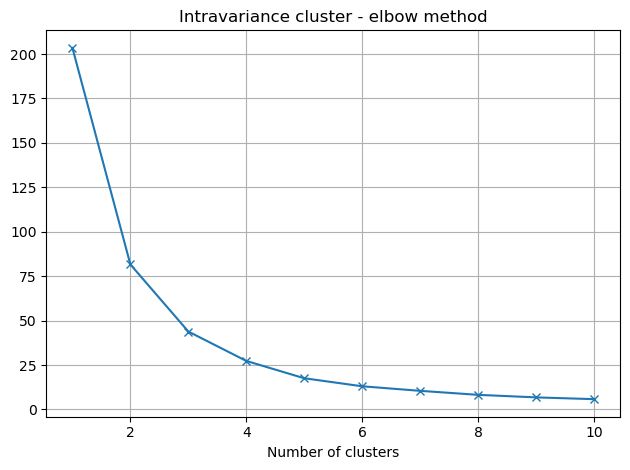

In [231]:
variances = np.array(variances)
pd.Series(variances[:,1], index = variances[:,0])\
    .plot(marker = 'x')

plt.title("Intravariance cluster - elbow method")
plt.xlabel("Number of clusters")
plt.tight_layout()
plt.grid()

## Silhouette score

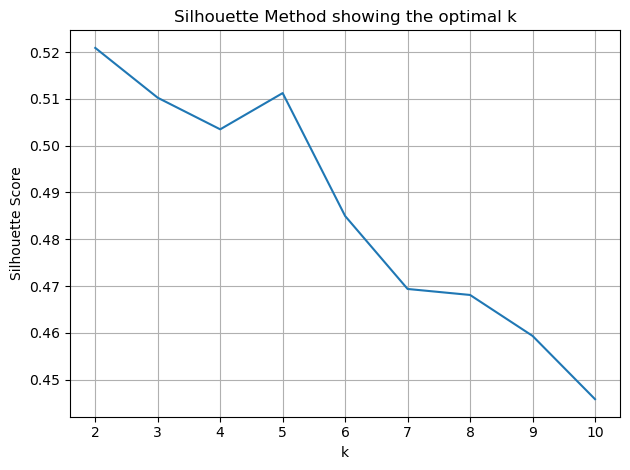

In [229]:
from sklearn.metrics import silhouette_score

silhouette_scores = [] 
range_values = range(2, 11)

for i in range_values:
    kmeans = KMeans(n_clusters=i).fit(daily_data_comsumptions)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(daily_data_comsumptions, labels, metric = 'euclidean'))

plt.plot(range_values, silhouette_scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method showing the optimal k')
plt.grid()
plt.tight_layout()
plt.show()